In [1]:
import os
import time
import re
import glob
import pandas as pd

%pylab inline
#This is what %pylab does:
# import numpy
# import matplotlib
# from matplotlib import pylab, mlab, pyplot
# np = numpy
# plt = pyplot
# from IPython.core.pylabtools import figsize, getfigs
# from pylab import *
# from numpy import *
#import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as clrs
import matplotlib.transforms as transforms
from matplotlib import style
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import skimage
from skimage import color, data, restoration
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.external import tifffile as tif
#print(skimage.__version__)

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.simplefilter('ignore', np.RankWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def find_transitions(amp, nm,
                     scale = 1.0,   # scale the results by this amount (in case of z-scaling)
                     bounds=[[0.37, 0.63], [0.2, 0.8]],
                     bands = [5 ,3, 5],
                     amp_scale = (0.0, 100.0),
                     clr = 'magenta',
                     vpos = 1.0,
                     cols=['brown', 'green', 'red', 'black' ],
                    disp_graph=False, ax=0, pref = 'X-', fs = 12):

    npts = len(amp)
    xc = dx2 = npts//2
    dxi, dxc, dxa = bands
    xnm = np.arange(npts) * nm * scale
    xc1=xc+1
    #xc1=xc
    
    ampi = mean(amp[0:dxi])
    ampa = mean(amp[-dxa:])
    amp_max = mean(amp[(xc1-dxc//2):(xc1+dxc//2)])
    damp = amp_max - np.min((ampi,ampa))
    #print(ampi, ampa, amp_max)

    if disp_graph:
        ax.plot(xnm,amp, color=clr, label = pref+'cross-section')
        ax.grid(True)
        ax.set_xlabel('Distance (nm)', fontsize=fs)
        ax.set_ylabel('Amplitude', fontsize=fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.set_ylim(amp_scale)
        ax.plot(xnm[0:dxi], amp[0:dxi]*0+ampi, color=clr, linestyle='--')
        ax.plot(xnm[-dxa:], amp[-dxa:]*0+ampa, color=clr, linestyle='--')
        ax.plot(xnm[(xc1-dxc//2):(xc1+dxc//2)], amp[(xc1-dxc//2):(xc1+dxc//2)]*0+amp_max, color=clr, linestyle='--')

    fall_points=[]
    rise_points=[]
    #first, finf half point: falling edge
    j=xc-1
    while (j<npts-1) and amp[j]>ampa+(amp_max-ampa)*0.5:
        '''
        if disp_graph:
            print('Rising edge, searching for xc:  ',j, amp[j], ampi+(amp_max-ampa)*0.5)
        '''
        j = j+1
    jhhf = j
    for kk, bound in enumerate(bounds):
        yi=ampa+bound[0]*(amp_max-ampa)
        ya=ampa+bound[1]*(amp_max-ampa)

        j = jhhf
        '''
        if disp_graph and kk==2:
            print('Falling edge, target yi={:.2f},  ya={:.2f}'.format(yi, ya))
            print('Falling edge range:   ', amp[jhhf-3:jhhf+3])
        '''
        while j<npts-1 and amp[j]>yi:
            j = j+1
            '''
            if disp_graph and kk==2:
                print('searching for xi: ', j, amp[j])
            '''
        xi = xnm[j-1] + (yi-amp[j-1])*(xnm[j]-xnm[j-1])/(amp[j]-amp[j-1])
        ja = j
        while j>0 and amp[j]<ya:
            j = j-1
            '''
            if disp_graph and kk==2:
                print('searching for xa: ', j, amp[j])
            '''
        xa = xnm[j] + (ya-amp[j])*(xnm[j+1]-xnm[j])/(amp[j+1]-amp[j])
        ji=j
        '''
        if disp_graph and kk==2:
            print(xnm[ji:ja+1], amp[ji:ja+1])
            ax.plot(xnm[ji:ja+1], amp[ji:ja+1], linewidth=2, color = 'orange')
        '''
        try: 
            [slope, offs] = np.polyfit(xnm[ji:ja+1], amp[ji:ja+1], 1)
        except:
            slope=0.0
        fall_points.append([xi, xa, yi, ya, abs((yi-ya)/slope)])

    if disp_graph:
        
        for (xi, xa, yi, ya, slope), bound, (m,col) in zip(fall_points, bounds, enumerate(cols)):
            if m == 0:
                ax.plot([xi, xa], [yi, ya], 'o', color = col, markersize = fs-2, markerfacecolor='none',
                    label = '{:.0f}%-{:.0f}%: {:.2f}nm'.format(bound[0]*100, bound[1]*100, abs(xa-xi)))
            else:
                ax.plot([xi, xa], [yi, ya], 'o', color = col, markersize = fs-2,
                    label = '{:.0f}%-{:.0f}%: {:.2f}nm'.format(bound[0]*100, bound[1]*100, abs(xa-xi)))
            xxx1 = xnm[xc]*1.3
            yyy1 = ax.get_ylim()[1] * vpos-0.08*damp*m
            #ax.text(xxx1, yyy1, '{:.0f}%-{:.0f}%={:.2f}nm'.format(100*bound[0], 100*bound[1], abs(xa-xi)), fontsize=fs-2, color=col)

    #first, finf half point: rising edge
    j=xc+1
    while (j>0) and amp[j]>ampi+(amp_max-ampi)*0.5:
        '''
        if disp_graph:
                print('Rising edge, searching for xc:  ',j, amp[j], ampi+(amp_max-ampi)*0.5)
        '''
        j = j-1

    jhhf = j+1
    for ll, bound in enumerate(bounds):
        yi=ampi+bound[0]*(amp_max-ampi)
        ya=ampi+bound[1]*(amp_max-ampi)
        j = jhhf
        '''
        if disp_graph and ll==2:
            print('Rising edge, target yi={:.2f},  ya={:.2f}'.format(yi, ya))
            print('Rising edge range:   ', amp[jhhf-3:jhhf+3])
        '''
        while j>0 and amp[j]>yi:
            j = j-1
            '''
            if disp_graph and ll==2:
                print('searching for xi:  ',j, amp[j])
            '''
        xi = xnm[j] + (yi-amp[j])*(xnm[j+1]-xnm[j])/(amp[j+1]-amp[j])
        ji = j
        while j<npts-1 and amp[j]<ya:
            j = j+1
            '''
            if disp_graph and ll==2:
                print('searching for xa:  ',j, amp[j])
            '''
        xa = xnm[j-1] + (xnm[j]-xnm[j-1])*(ya-amp[j-1])/(amp[j]-amp[j-1])
        ja=j
        '''
        if disp_graph and ll==2:
            print(xnm[ji:ja+1], amp[ji:ja+1])
            ax.plot(xnm[ji:ja+1], amp[ji:ja+1], linewidth=2, color = 'cyan')
        '''
        try:
            [slope, offs] = np.polyfit(xnm[ji:ja+1], amp[ji:ja+1], 1)
        except:
            slope=0.0
        rise_points.append([xi, xa, yi, ya, abs((yi-ya)/slope)])

    if disp_graph:
        for (xi, xa, yi, ya, slope), bound, (m,col) in zip(rise_points, bounds, enumerate(cols)):
            if m == 0:
                ax.plot([xi, xa], [yi, ya], 's', markersize = fs-2, color = col, markerfacecolor='none',
                    label = '{:.0f}%-{:.0f}%: {:.2f}nm'.format(bound[0]*100, bound[1]*100, abs(xa-xi)))
            else:
                ax.plot([xi, xa], [yi, ya], 's', markersize = fs-2, color = col,
                    label = '{:.0f}%-{:.0f}%: {:.2f}nm'.format(bound[0]*100, bound[1]*100, abs(xa-xi)))
            xxx1 = xnm[xc]*0.00
            yyy1 = ax.get_ylim()[1]*vpos-0.08*damp*m
            #ax.text(xxx1, yyy1, '{:.0f}%-{:.0f}%={:.2f}nm'.format(100*bound[0], 100*bound[1], abs(xa-xi)), fontsize=fs-2, color=col)
            
    return rise_points, fall_points, [ampi, ampa, amp_max]

In [3]:
def build_transitions_df(ampx, ampy, ampz, nm,
                     scale = 1.0):   # scale the results by this amount (in case of z-scaling)
    npts = len(ampx)
    lbls = ['X', 'Y', 'Z']
    col_hdrs = []
    data = []
    for amp, scl, lbl in zip([ampx, ampy, ampz], [1.0, 1.0, scale], lbls):
        col_hdrs.append(lbl+' distance (nm)')
        col_hdrs.append('Amplitude')
        xnm = np.arange(npts) * nm * scl
        data.append(xnm)
        data.append(amp)
    df_transitions = pd.DataFrame(data=(np.array(data)).T, index=None, columns = col_hdrs)
    return df_transitions

In [4]:
def add_hist(dt, nbins=64, hrange=(0, 10), ax=0, col='red', label=''):
    mn = np.mean(dt)
    md = np.median(dt)
    std = np.std(dt)
    y, x, _ = ax.hist(dt, bins=nbins, range=hrange, color=col, histtype='step', stacked=True, fill=False, linewidth=3, label = label)
    histmax_x = x[np.argmax(y)]+(x[1]-x[0])/2
    histmax_y = np.max(y)
    return x, y, histmax_x, md, mn, std

# 3D case

In [5]:
dt_fn = 'G:/FIB-SEM_resolution/Atlas_data_sets/SUM159_WT45_Cell2/SUM159_WT45_Cell2_subset.tif'
cond = 'SUM159 Cell2,     J1:  EHT=1200V, Bias=0V, f=200kHz, pix=4nm'
cond2 = 'Immortalized breast cancer cell (SUM159) 2017-11-21'
nm = 4.0

zscale = 1.14 # zpixels are nm*zscale as opposed to just nm for x-, y- 
# for this data set zscale=1.14 was determined by Shan Xu from WD and Z-milling voltages

dx = 16     # blob analysis window size in pixels
dx2=dx//2

bounds = [[0.37, 0.63], [0.2, 0.8]]
bands = [3, 2, 3]  # bands for finding left minimum, mid (peak), and right minimum

In [6]:
volume = np.squeeze(tif.imread(dt_fn)[:, :, :])*1.0
#volume = np.squeeze(tif.imread(dt_fn)[0:100, 500:1000, 500:1000])*1.0

min_sigma = 1.0
max_sigma = 2.5
threshold = 250

Step1: Data Greyscale Histogram Max is x=831.2, y=85649077.0
Step1: Done with log, found 12203 blobs


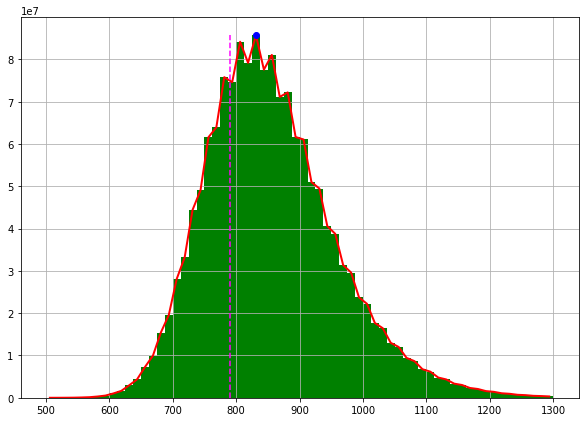

In [7]:
n_bins_st0 = 64
hr_st0 = (500, 1300)  # histogram range for identifying grey level distributions
dist_mult = 0.95  #The data is leveled: data = data - hist_max*dist_mult

rr = 5.0   # multiplier for circle display of blobs on the map
dp2f = volume.flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 7))#, sharex=True, sharey=True)
y, x, _ = ax.hist(dp2f, bins=n_bins_st0, range=hr_st0, color='green')
fs=14
ax.plot(x[0:-1]+(x[1]-x[0])/2, y, 'r',    linewidth=2)
ax.grid(True)
histmax_x = x[np.argmax(y)]+(x[1]-x[0])/2
histmax_y = np.max(y)
ax.plot(histmax_x,histmax_y, 'bo')
print('Step1: Data Greyscale Histogram Max is x={:.1f}, y={:.1f}'.format(histmax_x, histmax_y))
ax.plot([histmax_x*dist_mult, histmax_x*dist_mult], [0, histmax_y], color='magenta', linestyle = '--')
volume = volume - histmax_x*dist_mult

blobs_log_1024 = blob_log(volume, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
print('Step1: Done with log, found {:d} blobs'.format(len(blobs_log_1024)))

In [8]:
# Step 2: Select only "good" blobs
tr_xs_3763pts =[]
tr_ys_3763pts =[]
tr_zs_3763pts =[]

tr_xs_3763slp =[]
tr_ys_3763slp =[]
tr_zs_3763slp =[]

tr_xs_2080pts =[]
tr_ys_2080pts =[]
tr_zs_2080pts =[]

tr_xs_2080slp =[]
tr_ys_2080slp =[]
tr_zs_2080slp =[]


thr = 0.4  #threshold for identifying 'good' transition (bottom < thr* top)

select_blobs_1024 = []

for j, blob in enumerate(tqdm(blobs_log_1024)):
    z, y, x, r = blob
    xx = np.int(x)
    yy = np.int(y)
    zz = np.int(z)
    frmc = volume[zz-dx2:zz+dx2, yy-dx2:yy+dx2, xx-dx2:xx+dx2]
    if shape(frmc)==(dx, dx, dx) and np.mean(frmc)>0:
        amp_x = frmc[dx2, dx2, :]
        amp_y = frmc[dx2, :, dx2]
        amp_z = frmc[: , dx2, dx2]
        #print(shape(amp_x), shape(amp_y), shape(amp_z))
        tr_x = find_transitions(amp_x, nm,
                                scale = 1.0,
                        clr = 'magenta',
                         vpos = 1.0,
                         cols=['orange', 'red', 'brown', 'black' ],
                         bounds=bounds,
                        bands = bands,
                        disp_graph=False, ax=None, fs=10)
        
        tr_y = find_transitions(amp_y, nm,
                                scale = 1.0,
                        clr = 'lime',
                         vpos = 0.75,
                         cols=['cyan', 'blue', 'navy', 'black' ],
                         bounds=bounds,
                         bands = bands,
                        disp_graph=False, ax=None, fs=10)

        tr_z = find_transitions(amp_z, nm,
                                scale = zscale,
                        clr = 'red',
                         vpos = 0.75,
                         cols=['cyan', 'blue', 'navy', 'black' ],
                         bounds=bounds,
                         bands = bands,
                        disp_graph=False, ax=None, fs=10)
        
        max_tr = 15.0
        trx1 = abs(tr_x[0][0][1]- tr_x[0][0][0])
        trx2 = abs(tr_x[1][0][1]- tr_x[1][0][0])
        try1 = abs(tr_y[0][0][1]- tr_y[0][0][0])
        try2 = abs(tr_y[1][0][1]- tr_y[1][0][0])
        trz1 = abs(tr_z[0][0][1]- tr_z[0][0][0])
        trz2 = abs(tr_z[1][0][1]- tr_z[1][0][0])
        
        cr_trx = (tr_x[2][0] < thr*tr_x[2][2]) and (tr_x[2][1] < thr*tr_x[2][2]) and trx1<max_tr and trx2<max_tr and abs(tr_x[0][0][4])<max_tr and abs(tr_x[1][0][4])<max_tr
        cr_try = (tr_y[2][0] < thr*tr_y[2][2]) and (tr_y[2][1] < thr*tr_y[2][2]) and try1<max_tr and try2<max_tr and abs(tr_y[0][0][4])<max_tr and abs(tr_y[1][0][4])<max_tr
        cr_trz = (tr_z[2][0] < thr*tr_z[2][2]) and (tr_z[2][1] < thr*tr_z[2][2]) and trz1<max_tr and trz2<max_tr and abs(tr_z[0][0][4])<max_tr and abs(tr_z[1][0][4])<max_tr
        
        if cr_trx and cr_try and cr_trz:
            try:
                #print('appending')
                select_blobs_1024.append(blob)
                
                tr_xs_3763pts.append([trx1, trx2])
                tr_ys_3763pts.append([try1, try2])
                tr_zs_3763pts.append([trz1, trz2])
                
                tr_xs_3763slp.append([abs(tr_x[0][0][4]), abs(tr_x[1][0][4])])
                tr_ys_3763slp.append([abs(tr_y[0][0][4]), abs(tr_y[1][0][4])])
                tr_zs_3763slp.append([abs(tr_z[0][0][4]), abs(tr_z[1][0][4])])
                
                tr_xs_2080pts.append([abs(tr_x[0][1][1]- tr_x[0][1][0]), abs(tr_x[1][1][1]- tr_x[1][1][0])])
                tr_ys_2080pts.append([abs(tr_y[0][1][1]- tr_y[0][1][0]), abs(tr_y[1][1][1]- tr_y[1][1][0])])
                tr_zs_2080pts.append([abs(tr_z[0][1][1]- tr_z[0][1][0]), abs(tr_z[1][1][1]- tr_z[1][1][0])])
                
                tr_xs_2080slp.append([abs(tr_x[0][1][4]), abs(tr_x[1][1][4])])
                tr_ys_2080slp.append([abs(tr_y[0][1][4]), abs(tr_y[1][1][4])])
                tr_zs_2080slp.append([abs(tr_z[0][1][4]), abs(tr_z[1][1][4])])
            except:
                print('could not append blob')
                                               
print(shape(select_blobs_1024))

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars



(4397, 4)


In [9]:
columns_b = ['Z', 'Y', 'X', 'R']
b_data =  np.array(select_blobs_1024)
blobsd = pd.DataFrame(b_data, columns=columns_b)
blobsd.to_csv(dt_fn.replace('.tif', '_3D_blobs_data_v2.csv'))

In [10]:
select_blobs_1024 = pd.read_csv(dt_fn.replace('.tif', '_3D_blobs_data_v2.csv')).to_numpy()[:,1:5]

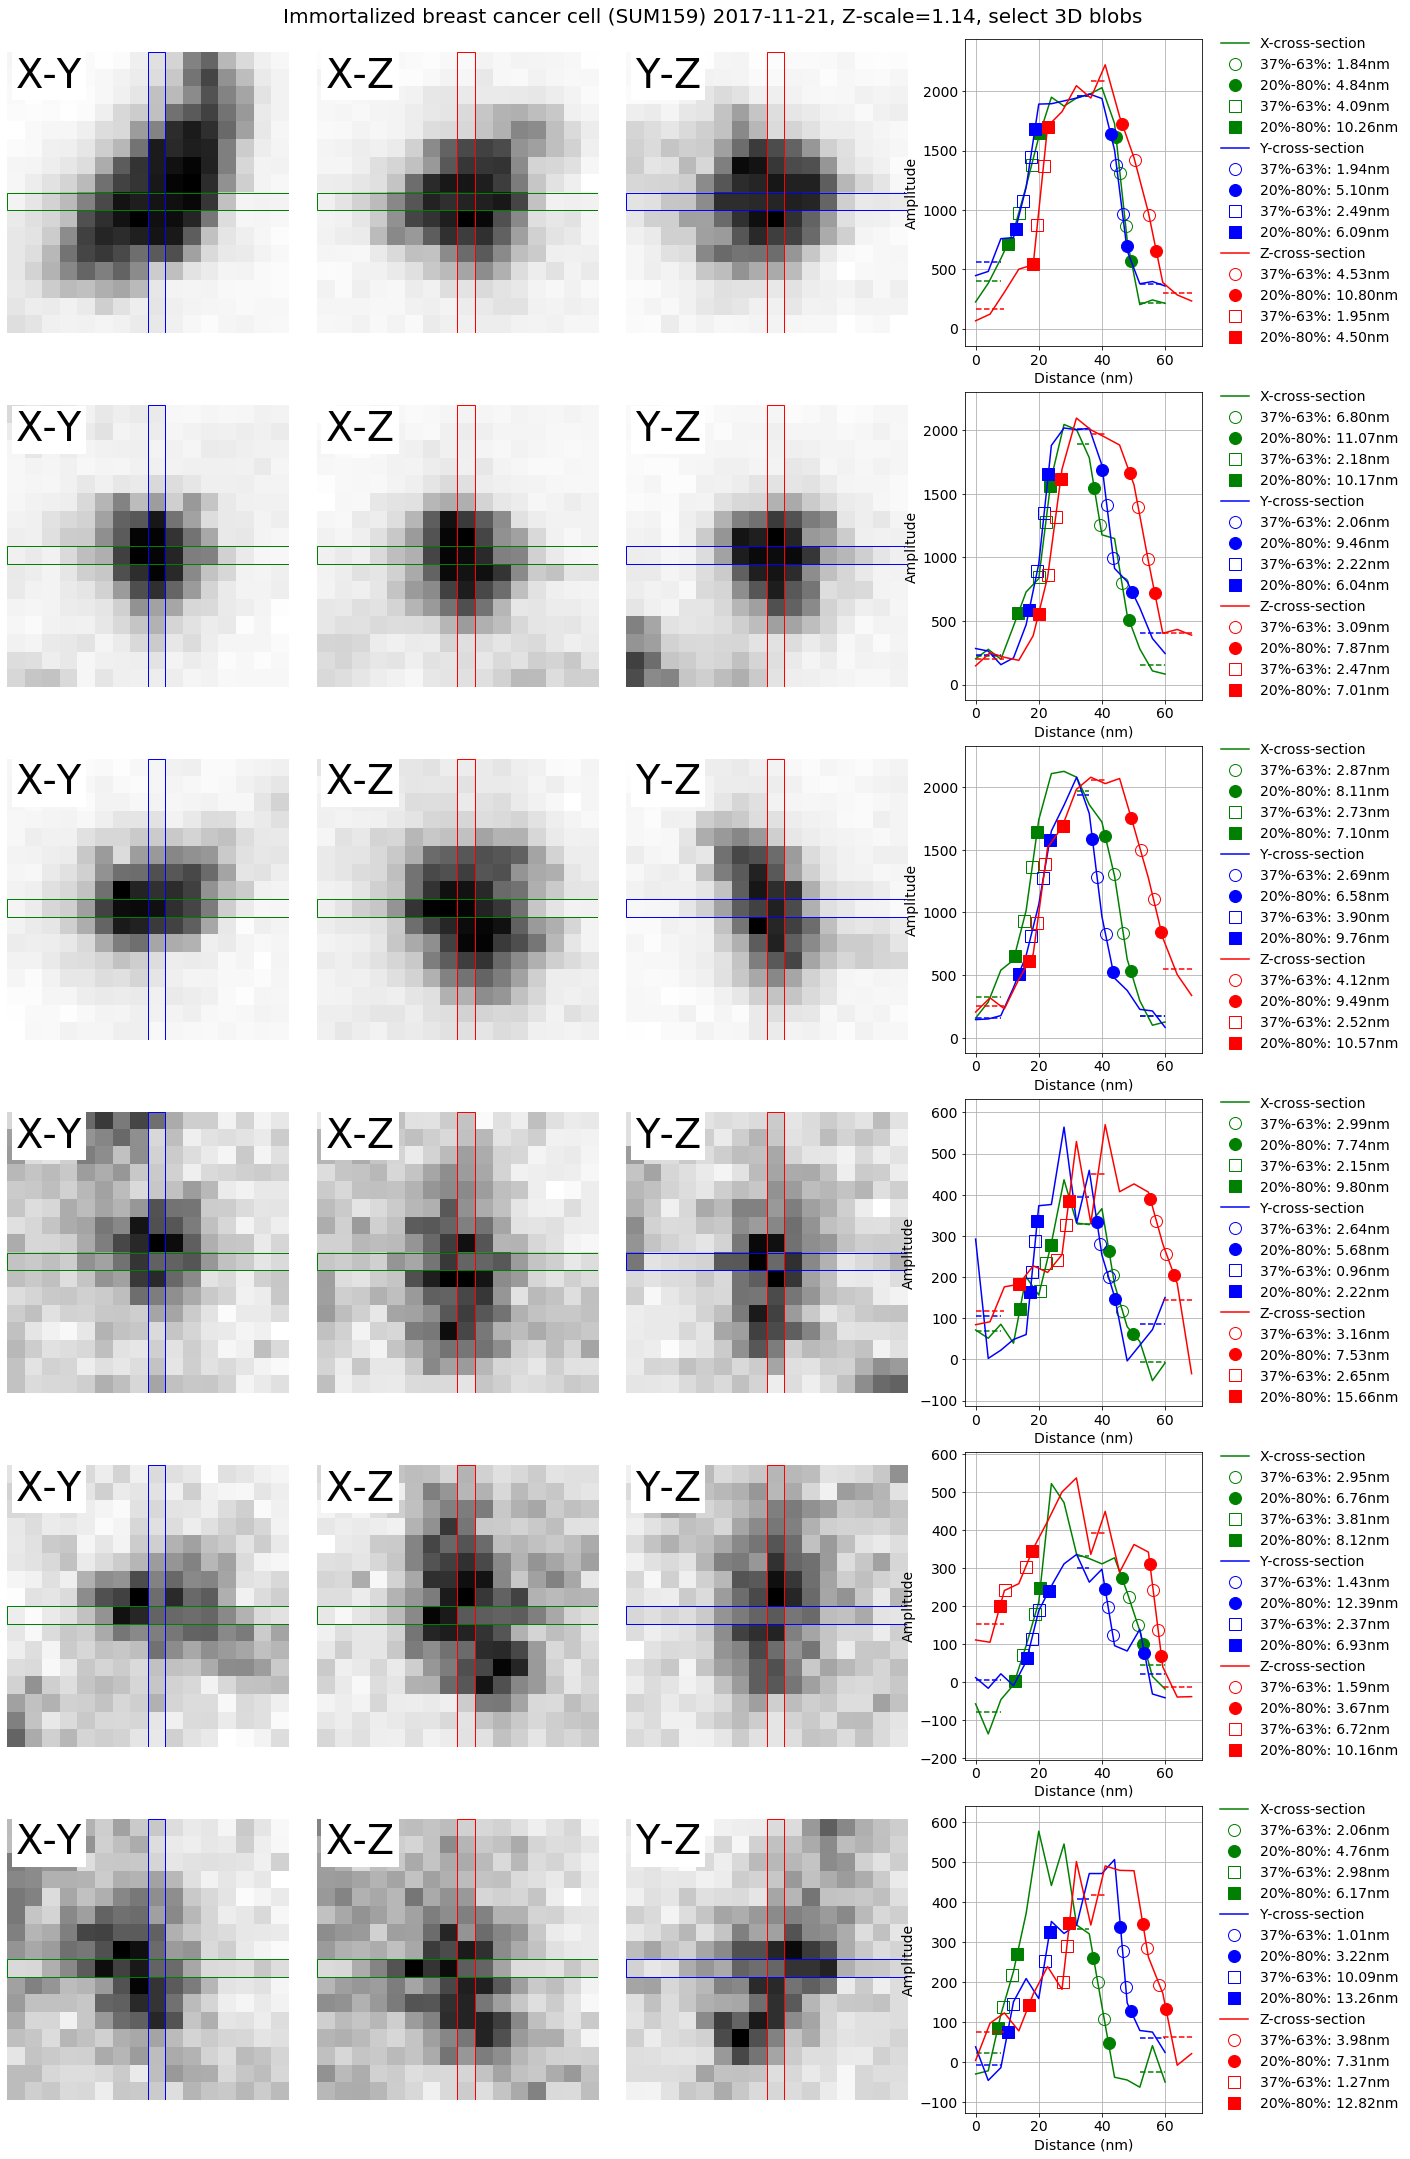

In [13]:
# Step 3  plot 6 select blobs"
fst = 40
fs = 12
fs1 = 14

xt = 0.0
yt=1.5
bands = [3, 2, 3]

xlsx_fname = os.path.join(os.path.dirname(dt_fn), cond2+'_select_blobs_transition_data.xlsx')
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(xlsx_fname, engine='xlsxwriter')

blob_log_amp = [volume[ np.int(z), np.int(y),  np.int(x)] for [z, y, x, r] in select_blobs_1024]
ind = np.concatenate((np.argsort(blob_log_amp)[-4:-1], np.argsort(blob_log_amp)[0:3]))
blobs_log12_1024 = np.array(select_blobs_1024)[ind]

clr_x = 'green'
clr_y = 'blue'
clr_z = 'red'
fig, axs = subplots(6,4, figsize=(20,30))
fig.subplots_adjust(left=0.01, bottom=0.02, right=0.85, top=0.98, wspace=0.1, hspace=0.15)

axr = axs.ravel()

for j, blob in enumerate(blobs_log12_1024):
    z, y, x, r = blob
    xx = np.int(x)
    yy = np.int(y)
    zz = np.int(z)
    frmc = volume[zz-dx2:zz+dx2, yy-dx2:yy+dx2, xx-dx2:xx+dx2]
    #print(np.mean(frmc))
    axr[4*j].imshow(frmc[dx2, :, :], cmap='Greys')#, vmin=0, vmax=160)
    axr[4*j].grid(False)
    axr[4*j].axis(False)
    crop_x = patches.Rectangle((-0.5,dx2-0.5),dx,1, linewidth=1, edgecolor=clr_x , facecolor='none')
    crop_y = patches.Rectangle((dx2-0.5, -0.5),1,dx, linewidth=1, edgecolor=clr_y, facecolor='none')
    axr[4*j].add_patch(crop_x)
    axr[4*j].add_patch(crop_y)
    axr[4*j].text(xt,yt,'X-Y', color='black',  bbox=dict(facecolor='white', edgecolor='none'), fontsize=fst)

    axr[4*j+1].imshow(frmc[:, dx2, :], cmap='Greys')#, vmin=0, vmax=160)
    axr[4*j+1].grid(False)
    axr[4*j+1].axis(False)
    crop_x = patches.Rectangle((-0.5,dx2-0.5),dx,1, linewidth=1, edgecolor=clr_x , facecolor='none')
    crop_z = patches.Rectangle((dx2-0.5, -0.5),1,dx, linewidth=1, edgecolor=clr_z, facecolor='none')
    axr[4*j+1].add_patch(crop_x)
    axr[4*j+1].add_patch(crop_z)
    axr[4*j+1].text(xt,yt,'X-Z', color='black',  bbox=dict(facecolor='white', edgecolor='none'), fontsize=fst)
    
    axr[4*j+2].imshow(frmc[:, :, dx2], cmap='Greys')#, vmin=0, vmax=160)
    axr[4*j+2].grid(False)
    axr[4*j+2].axis(False)
    crop_y2 = patches.Rectangle((-0.5,dx2-0.5),dx,1, linewidth=1, edgecolor=clr_y , facecolor='none')
    crop_z2 = patches.Rectangle((dx2-0.5, -0.5),1,dx, linewidth=1, edgecolor=clr_z, facecolor='none')
    axr[4*j+2].add_patch(crop_y2)
    axr[4*j+2].add_patch(crop_z2)
    axr[4*j+2].text(xt,yt,'Y-Z', color='black',  bbox=dict(facecolor='white', edgecolor='none'), fontsize=fst)

    amp_x = frmc[dx2, dx2, :]
    amp_y = frmc[dx2, :, dx2]
    amp_z = frmc[: , dx2, dx2]
    a0 = np.min(np.array((amp_x, amp_y, amp_z)))
    a1 = np.max(np.array((amp_x, amp_y, amp_z)))
    amp_scale = (a0-(a1-a0)/10.0, a1+(a1-a0)/10.0)
    #print(amp_scale)
    #print(shape(amp_x), shape(amp_y), shape(amp_z))
    tr_x = find_transitions(amp_x, nm,
                            scale = 1.0,
                    clr = 'green',
                     vpos = 0.95,
                     cols=['green', 'green', 'black' ],
                     bounds=bounds,
                      bands = bands,
                    amp_scale = amp_scale,
                    disp_graph=True, ax=axr[4*j+3], pref = 'X-', fs=fs1)
    tr_y = find_transitions(amp_y, nm,
                            scale = 1.0,
                    clr = 'blue',
                     vpos = 0.78,
                     cols=['blue', 'blue', 'black' ],
                     bounds=bounds,
                    bands = bands,
                            amp_scale = amp_scale,
                    disp_graph=True, ax=axr[4*j+3], pref = 'Y-', fs=fs1)
    tr_z = find_transitions(amp_z, nm,
                            scale = zscale,
                    clr = 'red',
                     vpos = 0.61,
                     cols=['red', 'red', 'black' ],
                     bounds=bounds,
                     bands = bands,
                            amp_scale = amp_scale,
                    disp_graph=True, ax=axr[4*j+3], pref = 'Z-', fs=fs1)
            #ppd = 72./fig.dpi  # points per dot
    mybbox = axr[4*j+3].get_position()
        #print(mybbox)
    mybbox.x0 = 0.675
    mybbox.x1 = 0.84
    axr[4*j+3].set_position(mybbox)
    axr[4*j+3].legend(loc='upper center', bbox_to_anchor=(1.45,1.05), fancybox=False, edgecolor="w", fontsize = fs1)
    # save into a new excel sheet
    tr_df = build_transitions_df(amp_x, amp_y, amp_z, nm, zscale)
    tr_df.to_excel(writer, index=None, sheet_name='Blob{:d}'.format(j+1))
fig.suptitle(cond2 + ', Z-scale={:.2f}, select 3D blobs'.format(zscale), fontsize=20,y=0.995)
#fname_blobs = dt_fn.replace('.tif', ('_3D_blob_examples_zscale{:.2f}_v3.png'.format(zscale)))
fname_blobs = xlsx_fname.replace('.xlsx', '.png')
writer.save()
fig.savefig(fname_blobs, dpi=300)

Step4: nm check:  4.0
working on the set _3763pts


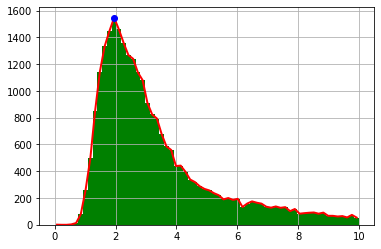

tr_xy   2.5615956888365687 3.0590416300464103 1.7312776604532842


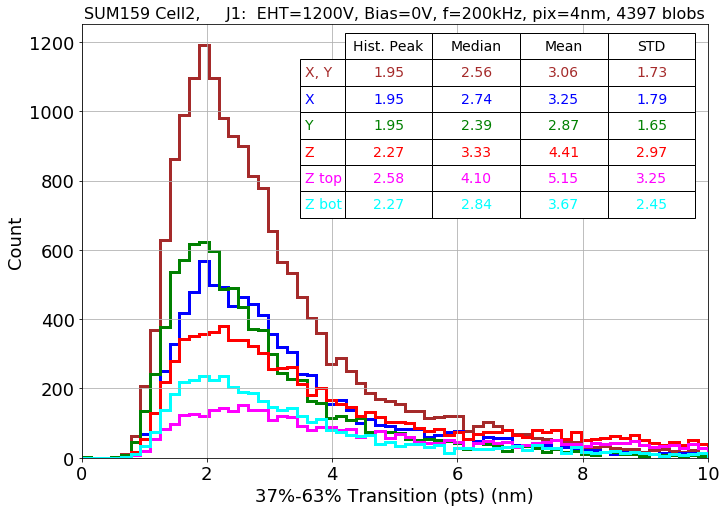

working on the set _3763slp


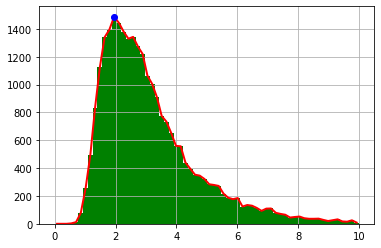

tr_xy   2.568269933667246 2.8312124381283303 1.2996266091250372


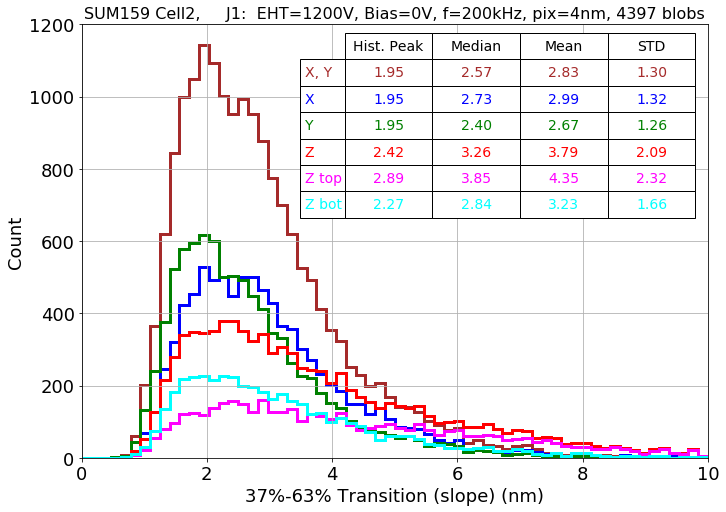

working on the set _2080pts


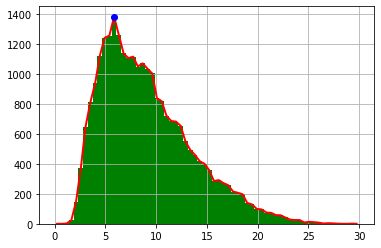

tr_xy   7.281567063039461 7.785327069064588 3.3251257856923635


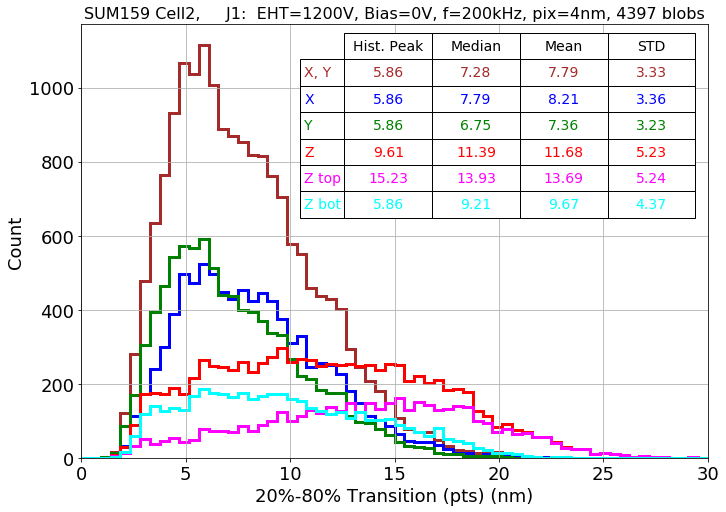

working on the set _2080slp


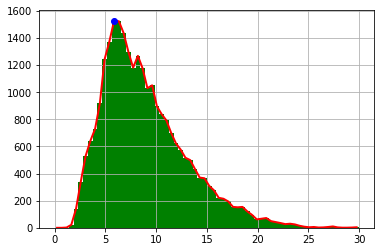

tr_xy   7.191013030685152 7.684268105672008 3.0792782797226406


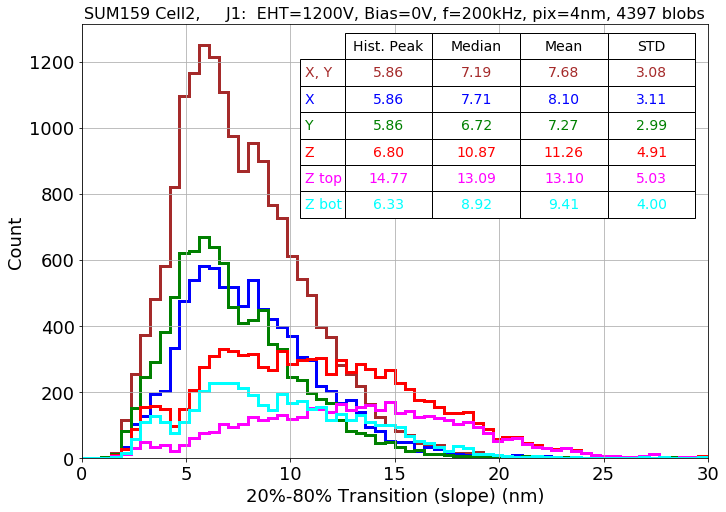

,Transition,Hist. Peak,Median,Mean,STD
0,All,5.859375,8.081494,8.875152,4.144654
1,"X, Y",5.859375,7.191013,7.684268,3.079278
2,X,5.859375,7.709665,8.101683,3.114549
3,Y,5.859375,6.717093,7.266853,2.985803
4,Z,6.796875,10.873551,11.256920,4.905235
5,Z top,14.765625,13.090731,13.104727,5.028692
6,Z bot,6.328125,8.923071,9.409114,4.000767


In [12]:
print('Step4: nm check: ', nm)

fs=18

n_bins_st4 = 64  # number of bins for the transition distances


tr_sets = [[tr_xs_3763pts, tr_ys_3763pts, tr_zs_3763pts],
          [tr_xs_3763slp, tr_ys_3763slp, tr_zs_3763slp],
          [tr_xs_2080pts, tr_ys_2080pts, tr_zs_2080pts],
          [tr_xs_2080slp, tr_ys_2080slp, tr_zs_2080slp]]
fexts =['_3763pts', '_3763slp', '_2080pts', '_2080slp']
xaxis_labels = ['37%-63% Transition (pts) (nm)',
        '37%-63% Transition (slope) (nm)',
        '20%-80% Transition (pts) (nm)',
         '20%-80% Transition (slope) (nm)']
hranges = [(0, 10.0), 
           (0, 10.0),
           (0, 30.0),
           (0, 30.0)]  # histogram range for the transition distance (in nm))

for [tr_xs_1024, tr_ys_1024, tr_zs_1024], fext, xaxis_label, hrange_st4 in zip(tr_sets, fexts, xaxis_labels, hranges):
    print('working on the set '+fext)
    trs = np.squeeze(np.array((tr_xs_1024, tr_ys_1024, tr_zs_1024)).flatten())
    tr_xy = np.squeeze(np.array((tr_xs_1024, tr_ys_1024)).flatten())
    tr_x = np.array(tr_xs_1024).flatten()
    tr_y = np.array(tr_ys_1024).flatten()
    tr_z = np.array(tr_zs_1024).flatten()
    tr_ztop = np.array([tr[0] for tr in tr_zs_1024])
    tr_zbot = np.array([tr[1] for tr in tr_zs_1024])

    fig0, ax0 = plt.subplots(1, 1, figsize=(6, 4))#, sharex=True, sharey=True)
    y_st4, x_st4, _ = ax0.hist(trs, bins=n_bins_st4, range=hrange_st4, color='green', label = 'Vertical Trans.')

    ax0.plot(x_st4[0:-1]+(x_st4[1]-x_st4[0])/2, y_st4, 'r',    linewidth=2)
    ax0.grid(True)
    histmax_x_st4 = x_st4[np.argmax(y_st4)]+(x_st4[1]-x_st4[0])/2
    histmax_y_st4 = np.max(y_st4)

    ax0.plot(histmax_x_st4,histmax_y_st4, 'bo')
    #print('Step4: All Transitions Histogram Max is x={:.1f}, y={:.1f}'.format(histmax_x_st4, histmax_y_st4))
    hist_data_st4 = [histmax_x_st4, np.median(trs)]
    plt.show()

    #print('Step4: All Transitions Histogram Median {:.2f}'.format(np.median(trs)))

    #print('Step4: X-Y Transitions Histogram Median {:.2f}'.format(np.median(tr_xy)))
    #print('Step4: Z Transitions Histogram Median {:.2f}'.format(np.median(tr_z)))

    fig4, ax = plt.subplots(1, 1, figsize=(10, 7))
    fig4.subplots_adjust(left=0.11, bottom=0.09, right=0.98, top=0.95, wspace=0.05, hspace=0.1)
    dsets = [tr_xy, tr_x, tr_y, tr_z, tr_ztop, tr_zbot]
    cols = ['brown', 'blue', 'green', 'red', 'magenta', 'cyan']
    hst_data =  np.zeros((len(dsets), 4))
    full_hst_data =  np.zeros((len(dsets)+1, 4))
    full_hst_data[0, :] = np.array((histmax_x_st4, np.median(trs), np.mean(trs), np.std(trs)))
    cc_data =  np.zeros((n_bins_st4, len(dsets)+2))
    
    print('tr_xy  ', np.median(tr_xy), np.mean(tr_xy), np.std(tr_xy))
    for (j, dset), col in zip(enumerate(dsets), cols):
        hst_res = np.array(add_hist(dset, nbins=n_bins_st4, hrange=hrange_st4, ax=ax, col=col, label=''))
        hst_data[j, :]=hst_res[2:7]
        full_hst_data[j+1, :] = hst_data[j, :]
        cc_data[:, j+2] = hst_res[1]
    ax.grid(True)
    ax.set_xlim(hrange_st4)
    ax.set_xlabel(xaxis_label, fontsize=fs)
    ax.set_ylabel('Count', fontsize=fs)
    plt.tick_params(labelsize = fs)
    cond_bl = cond +', {:d} blobs'.format(len(tr_x)//2)
    ax.set_title(cond_bl, fontsize=fs-2)

    columns = ['Hist. Peak', 'Median', 'Mean', 'STD']
    rows = ['X, Y', 'X', 'Y', 'Z', 'Z top', 'Z bot']
    n_cols = len(columns)
    n_rows = len(rows)
    cell_text = [['{:.2f}'.format(d) for d in dd] for dd in hst_data]

    tbl = ax.table(cellText=cell_text,
                     rowLabels=rows,
                     colLabels=columns,
                     colWidths=[0.14]*len(cols),
                     cellLoc='center',
                     colLoc='center',
                     loc=1,
                     zorder=10)

    tbl.scale(1.0, 2.2)
    table_props = tbl.properties()
    table_cells = table_props['child_artists']

    for j, cell in enumerate(table_cells[0:n_cols*n_rows]):
        cell.get_text().set_color(cols[j//n_cols])
        cell.get_text().set_fontsize(fs)
    for j, cell in enumerate(table_cells[n_cols*(n_rows+1):]):
        cell.get_text().set_color(cols[j])
    for cell in table_cells[n_cols*n_rows:]:
    #    cell.get_text().set_fontweight('bold')
        cell.get_text().set_fontsize(fs)

    fname_tr = dt_fn.replace('.tif', fext+'_3D_blob_AllTr_and_Ztr_histograms_zscale{:.2f}_v2.png'.format(zscale))
    fig4.savefig(fname_tr, dpi=300)
    plt.show()

    #now save all the data
    textfile = open(dt_fn.replace('.tif', fext+'_cond.txt'), 'w')
    textfile.write(cond_bl)
    textfile.close()

    blob_data = pd.DataFrame(full_hst_data, columns=columns)
    full_rows = ['All','X, Y', 'X', 'Y', 'Z', 'Z top', 'Z bot']
    blob_data.insert(loc=0, column='Transition', value = full_rows)
    blob_data.to_csv(dt_fn.replace('.tif', fext+'_3D_blob_distribution_data_zscale{:.2f}_v2.csv'.format(zscale)))

    columns = [xaxis_label, 'X-Y-Z', 'X-Y', 'X', 'Y', 'Z', 'Ztop', 'Zbot' ]
    x= x_st4[0:-1]+(x_st4[1]-x_st4[0])/2.0

    cc_data[:, 0] = x
    cc_data[:, 1] = y_st4
    Histograms = pd.DataFrame(cc_data, columns=columns)
    Histograms.to_csv(dt_fn.replace('.tif', fext+'_3D_blob_histogram_data_zscale{:.2f}_v2.csv'.format(zscale)))

blob_data